In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
#Ignore warnings
import warnings
import scipy
from datetime import datetime
from platform import python_version
import statsmodels.api as sm
import matplotlib.dates as mdates
print(python_version())
warnings.filterwarnings('ignore')

3.9.7


['Adur', 'Allerdale', 'Amber Valley', 'Arun', 'Ashfield', 'Ashford', 'Aylesbury Vale', 'Babergh', 'Barking and Dagenham', 'Barnet', 'Barnsley', 'Barrow-in-Furness', 'Basildon', 'Basingstoke and Deane', 'Bassetlaw', 'Bath and North East Somerset', 'Bedford', 'Bexley', 'Birmingham', 'Blaby', 'Blackburn with Darwen', 'Blackpool', 'Blaenau Gwent', 'Bolsover', 'Bolton', 'Boston', 'Bournemouth', 'Bracknell Forest', 'Bradford', 'Braintree', 'Breckland', 'Brent', 'Brentwood', 'Bridgend', 'Brighton and Hove', 'Bristol', 'Broadland', 'Bromley', 'Bromsgrove', 'Broxbourne', 'Broxtowe', 'Burnley', 'Bury', 'Caerphilly', 'Calderdale', 'Cambridge', 'Camden', 'Cannock Chase', 'Canterbury', 'Cardiff', 'Carlisle', 'Carmarthenshire', 'Castle Point', 'Central Bedfordshire', 'Ceredigion', 'Charnwood', 'Chelmsford', 'Cheltenham', 'Cherwell', 'Cheshire East', 'Cheshire West and Chester', 'Chesterfield', 'Chichester', 'Chiltern', 'Chorley', 'Christchurch', 'City of London', 'Colchester', 'Conwy', 'Copeland', '

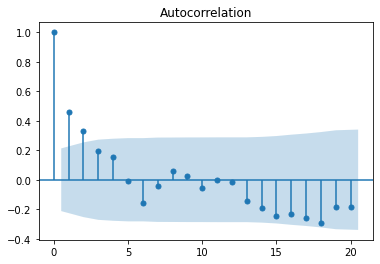

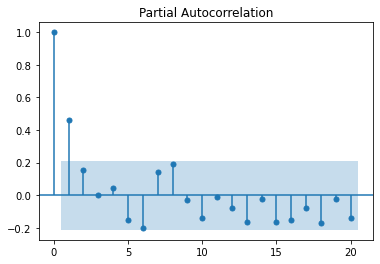

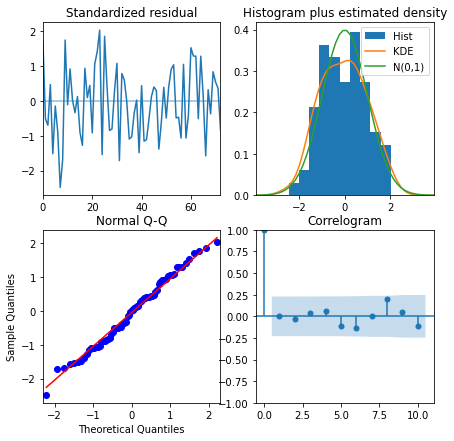

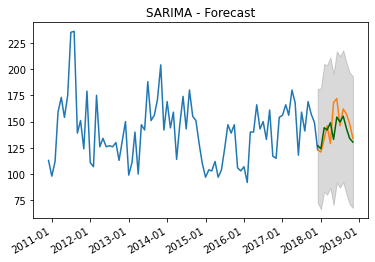

In [49]:
burg = 'burglarys city'
col = burg
n_periods = 12
city = 'Blackpool'

df = pd.read_csv('C:\\Users\\20203666\\Documents\\JBG050-data\\final_burglary_data_city1.csv')
print(sorted(df['city'].unique()))
df['year month'] = [datetime.strptime(date, '%Y-%m') for date in df['year month']]
df_city = df.loc[df['city'] == city]
# Reset index to stop expected value error

df_city_index_reset = df_city.reset_index(drop = True)

#Sort it on year/month to perform ARIMA
df_city_sorted = df_city_index_reset.set_index(df_city_index_reset['year month'])

#Create test partition
df_city_train = df_city_sorted['2010-12':'2017-12']
df_city_test  = df_city_sorted['2017-12':'2019-12']
plot_acf(df_city_train[col].dropna())
plot_pacf(df_city_train[col].dropna())

smodel = auto_arima(df_city_train[col].dropna(), start_p=1, start_q=1,
                    test='adf',
                    max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=True,
                    d=0, D=1, trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)
print(smodel.summary())

fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = df_city_test.index[:n_periods]

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

smodel.plot_diagnostics(figsize=(7, 7))
plt.show()

# Plot
plt.plot(df_city_train[col].dropna())
plt.plot(df_city_test[col][:n_periods].dropna())
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.title("SARIMA - Forecast")
plt.show()

In [51]:
print('MAE:', mean_absolute_error(df_city_test[col][:n_periods].dropna(), fitted_series))
print("R2:", r2_score(df_city_test[col][:n_periods].dropna(), fitted_series))

MAE: 11.395661631481063
R2: 0.22074336866335809
